In [1]:
import numpy as np
import os
from scipy import signal
# import UDIP_Lib.UDIP_Lib_V19 as UDIP_Lib  #making updating UDIP_Lib easier
import Fitting.RockSat_1_14_fitting_functions as R_fitting
import json
import pandas as pd
import matplotlib.pyplot as plt
from RockSat_json.RockSat_json import *

In [2]:
!pwd

/Users/joshuagoodwill/Library/CloudStorage/GoogleDrive-goodwill@udel.edu/My Drive/DAPPEr_Dr/base


In [3]:
packets = import_data('../UDIP4/data/json/UDIP_4_800s.json')
# def get_sweep(sw, cn = 0):

#   start = sw['Start']
#   stop =  sw['Stop']

#   sw['Voltage'] = np.array(sw['Voltage'])
#   sw[f'Current{cn}'] = np.array(sw[f'Current{cn}'])



In [10]:
print(packets['packets']['Full']['0']['Stop']/1000)

108.346


In [15]:
sw = 400
V = packets['packets']['Full'][f'{sw}']['Voltage']
I = packets['packets']['Full'][f'{sw}']['Current0']

print(packets['packets']['Full'][f'{sw}']['Stop']/1000)


262.325


In [16]:
import pandas as pd

df = pd.DataFrame({'Voltage': V, 'Current': I})
df.to_csv(f'IV_{sw}.csv')

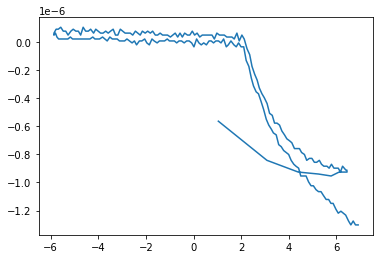

In [58]:
plt.plot(V,I)

In [59]:
# packets['packets']['Sensor']['100'].keys()
packets['packets']['Full']['100'].keys()

dict_keys(['Start', 'Stop', 'Count', 'GroundType', 'Voltage', 'Current0', 'Current1', 'Current2', 'PhotoDiodeInitial', 'PhotoDiodeFinal'])

In [60]:
#0 - Grounded to rocket
#1 - Disconnected

In [61]:
sw = packets['packets']['Full']['360']
print(sw.keys())
print(sw['GroundType'])
time = sw['Start']/1000

V = sw['Voltage'][6:]
I = -1 * np.array(sw['Current0'][6:])

V1 = sw['Voltage'][6:128]
I1 = -1 * np.array(sw['Current0'][6:128])

V2 = sw['Voltage'][128:]
I2 = -1 * np.array(sw['Current0'][128:])

dict_keys(['Start', 'Stop', 'Count', 'GroundType', 'Voltage', 'Current0', 'Current1', 'Current2', 'PhotoDiodeInitial', 'PhotoDiodeFinal'])
0


In [62]:
import scipy.optimize as optimize
def gen_fit(x_raw,y_raw):
    # x,y = data_processing(x_raw,y_raw)
    x,y = x_raw, y_raw
    # g = [0.6,-14,80, 5*(10**10),1000,-0.5]    #intial guess
    b = ((-3,-np.inf,-np.inf,0,0,-3),(3,np.inf,np.inf,np.inf,10000,3)) #bounds
    popt, pcov = optimize.curve_fit(model, x, y, bounds=b)
    #print(popt)
    max_1 = max(x)
    min_1 = min(x)
    t = np.linspace(min_1,max_1,num=60)
    return t, model(t,*popt),popt,pcov #popt[0:xa,1:b,2:m1,3:n,4:t,5:V0]

def model(x,xa,b,m1,n,t,V0):
    #changed to be hopefully more effeicent
    ret = np.zeros(len(x))
    ret[x <= xa] = seg1(x[x <= xa],m1) - seg1(xa, m1) + b
    ret[x > xa] = seg2(x[x > xa],n,t,V0) - seg2(xa,n,t,V0) + seg1(xa,m1) - seg1(xa, m1) + b
    return ret

def seg1(x,m):#linear--full model square root
    return m * x

def seg2(x,n,t,V0):# square root
    q_e = 1.602 * 10**-19 #C                charge of an electron
    K_b = 1.381 * 10**-23 #m^2*kg/(s^2*K)   boltzman constant
    m_e = 9.109 * 10**-31 #kg               mass of an electron
    R = (3./16.) * 0.0254 #radius of probe
    L = (3.25) * 0.0254 #length of probe
    A = 2. * np.pi * R * L + np.pi * (R ** 2) #area of probe cylinder with out a bottom

    k = q_e / (K_b * t)
    I0 =n * q_e * np.sqrt(K_b * t / (2. * np.pi * m_e)) * A / (10**-9)
    return I0 * np.sqrt(1. + k*(x + V0))

In [63]:
# """
# Created on March 25, 2023

# @author: Josh Goodwill
# """

# import numpy as np
# from scipy.optimize import curve_fit

# '''
# def gen_fit(x, y):
# Generates fit of linear and sqrt portion of IV arrays. Refer to
# data_processing to idenify filtering of IV arrays. scipy.optimize.curve_fit
# used to fit non-linear least squares to fit


# input:
# V_arr (array); Voltage array
# I_arr (array); Current array
# proc* (boolean); Whether to process the arrays for better fitting

# output:
# V_fit (np.array); linear space between min and max voltages from V_arr
# model(t, *popt) (np.array); fitted model of I_arr using Voltage range and 
#                             pointer to popt
# popt(array); optimal values for parameters
#   V_f  (float) = popt[0]; floating potential
#   m1   (float) = popt[1]; slope of linear fit
#   b    (float) = popt[2]; y-intercept of linear fit
#   a    (float) = popt[3]; multiplication factor of exponential fit
#   ne   (float) = popt[4]; electron density [cm^{-3}]
#   etemp(float) = popt[5]; electron temperature [K]
#   VP   (float) = popt[6]; plasma potential [V]
  
# Intial guesses/[bounds]:
#     V_f   = 0.3   ; [0: 0.5]
#     m1    = 100   ; [-1000:1000]
#     b     = 80    ; [-100:100]
#     a     = 5     ; [0:100]
#     ne    = 8*10^8; [0, np.inf]
#     etemp = 1000  ; [0, 10000]
#     VP    = 0.9   ; [0.5, 1.5]

# pcov(2D np.array); covariance of popt array
# '''

# def gen_fit(V_arr, I_arr, proc = False):
#     V_proc = []
#     I_proc = []
#     if proc == True:
#         V_proc, I_proc = data_processing(V_arr, I_arr)
#     else:
#         V_proc, I_proc = V_arr, I_arr
#     guess = [0.3, 0.9, 100, 80,  2,  8*(10**10), 1000]    #intial guess
#     b = ((0, 0.5, -1000,-100, 0, 0, 0),(3, 1.5, 1000,100, 100, np.inf,10000)) #bounds

#     # guess = [0.5, 100, 80, 1000, 0.5, 1]    #intial guess
#     # b = ((0, -1000, -100, 0, 0, 0.5),(1, 1000, 100, 10000, 100, 3)) #bounds

#     popt, pcov = curve_fit(model, V_proc, I_proc, bounds = b)
#     # popt, pcov = curve_fit(model, V_proc, I_proc)
#     V_fit = np.linspace(min(V_proc),max(V_proc), num = 300) #Voltage array processed for fit
#     return V_fit, model(V_fit,*popt), popt, pcov

# '''
# def model(V_proc, VP, m1, b, ne, etemp, V0):
# Model to fit ion, *transition*, electron saturation regions

# input:
# V_proc (np.array); processed V_arr for fitting
# Vf (float); floating potential
# m1 (float); slope of linear fit
# b  (float); y-intercept of linear fit
# ne (float); electron density [cm^{-2}]
# etemp(float); electron temperature [K]
# VP (float); plasma potential [V]
# '''

# def model(V_proc, Vf, VP, m1, b, a, ne, etemp):
#     I_fit = np.zeros(len(V_proc))
#     #Linear fit for ion saturation
#     I_fit[V_proc <= Vf] = lin_fit(V_proc[V_proc <= Vf], m1, b)
#     I1_cont =  -(exp_fit(Vf, a, etemp, Vf) + lin_fit(Vf, m1, b))
#     #Exp fit for transition region
#     # I_fit[(V_proc > Vf) & (V_proc <= VP)] = exp_fit(V_proc[(V_proc > Vf) & (V_proc <= VP)], a, etemp,  Vf) + I1_cont
#     # I2_cont = -(exp_fit(VP, a, etemp,  Vf) + I1_cont)
#     #Sqrt fit for electron saturation
#     I_fit[V_proc > VP] = sqrt_fit(V_proc[V_proc > VP], ne, etemp ,VP) + I1_cont
#     return I_fit

# def lin_fit(x, m, y_int): #linear--full model square root
#     return m * x + y_int

# def exp_fit(x, a, etemp, Vf): #exponential fit
#     q_e = 1.602 * 10**-19 #electron charge [C]
#     K_b = 1.381 * 10**-23 #boltzman constant [m^2*kg/(s^2*K)]   
#     k = q_e / (K_b * etemp)
#     return a * np.exp(k * (x - Vf))

# '''
# def sqrt_fit(x, ne, etemp, V0)
# Uses Eq. 1.4 and 1.5 of https://digitalcommons.usu.edu/etd/274

# input:
# x (np.array); V_proc [V]
# ne (float); electron density [cm?]
# etemp(float); electron temperature [K]
# VP (float); negative plasma potential [V]

# output:
# I (float); current fit [nA]
# '''
# def sqrt_fit(x, ne, etemp, VP):# square root
#     q_e = 1.602 * 10**-19 #electron charge [C]
#     K_b = 1.381 * 10**-23 #boltzman constant [m^2*kg/(s^2*K)]   
#     m_e = 9.109 * 10**-31 #electron mass [kg]              
#     R = (3./16.) * 0.0254 #radius of probe [cm?]
#     L = (3.25) * 0.0254 #length of probe [cm?]
#     A = 2. * np.pi * R * L + np.pi * (R ** 2) #top and length area of cylinder [cm^2]

#     k = q_e / (K_b * etemp)
#     I0 = ne * q_e * np.sqrt(K_b * etemp / (2. * np.pi * m_e)) * A / (10**-9)
#     return I0 * np.sqrt(1. + k*(x - VP))

# '''
# def data_processing(V, I)
# Processes Voltage and Current arrays to reduce points for fitting algorithm.
# Removes Voltage below -3 V and above first max of Current array

# input:
# V (np.array); Normal Voltage array
# I (np.array); Normal Current array

# output:
# V_proc (np.array); processed Voltage array
# I_proc (np.array); processed Current array
# '''

# def data_processing(V, I):
#     Imax = np.argmax(I) #find index of maximum Current
#     if (Imax.size != 1):
#         Vmin_Imax = np.argmin(V[Imax]) #find lowest voltage value with max current
#     else:
#         Vmin_Imax = Imax
#     V_rem = (V > -3) & (V < V[Vmin_Imax]) #array of voltages > -3V and < Vmin_Imax
#     V_proc = V[V_rem]
#     I_proc = I[V_rem]
#     return V_proc, I_proc


In [64]:
import pandas as pd

# Load the IV.csv file to inspect its structure and data
file_path = 'IV.csv'
iv_data = pd.read_csv(file_path)

# Display the first few rows of the dataset to understand its structure
iv_data.head()


,Unnamed: 0,Voltage,Current
0,0,1.038123,-5.641496e-07
1,1,3.078812,-8.427419e-07
2,2,4.395161,-9.263196e-07
3,3,5.244868,-9.402493e-07
4,4,5.774194,-9.541789e-07


In [65]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# Extract Voltage and Current from the dataset
voltage = iv_data["Voltage"].values
current = -iv_data["Current"].values * 1e9

# Define the model function (as fixed in the earlier script)
# def model(V_proc, Vf, VP, m1, b, ne, etemp):
#     I_fit = np.zeros(len(V_proc))
#     I_fit[V_proc <= Vf] = lin_fit(V_proc[V_proc <= Vf], m1, b)
#     I1_cont = -(exp_fit(Vf, ne, etemp, Vf) + lin_fit(Vf, m1, b))
#     mask_transition = (V_proc > Vf) & (V_proc <= VP)
#     I_fit[mask_transition] = exp_fit(V_proc[mask_transition], ne, etemp, Vf) + I1_cont
#     I2_cont = exp_fit(VP, ne, etemp, Vf) + I1_cont
#     I_fit[V_proc > VP] = sqrt_fit(V_proc[V_proc > VP], ne, etemp, VP) + I2_cont
#     return I_fit

# def model(V, Vf, b, m1, ne, etemp, V0):
#     I_fit = np.zeros(len(V))
#     I_fit[V <= Vf] = lin(V[V <= Vf], m1) - lin(Vf, m1) + b
#     I_fit[V > Vf] = sqrt(V[V > Vf], ne, etemp, V0) - sqrt(Vf,ne,etemp,V0) + lin(Vf, m1) - lin(Vf,m1) + b
#     return I_fit

def model(V, Vf, b, m, ne, te, V0):
    I = np.zeros(len(V))
    I[V <= Vf] = lin(V[V <= Vf], m) - lin(V, m) + b
    I[V > Vf] = sqrt(V[V > Vf], ne, te, V0) - sqrt(Vf, ne, te, V0) + lin(Vf, m) - lin(Vf, m) + b
    return I

# Supporting functions: lin_fit, exp_fit, sqrt_fit
def lin(x, m1):
    return m1 * x

# def exp_fit(x, ne, etemp, Vf):
#     q_e = 1.602e-19  # Electron charge [C]
#     K_b = 1.381e-23  # Boltzmann constant [J/K]
#     m_e = 9.109e-31  # Electron mass [kg]
#     R = (3.0 / 16.0) * 2.54  # Radius of probe [cm]
#     L = 3.25 * 2.54  # Length of probe [cm]
#     A = 2.0 * np.pi * R * L + np.pi * (R ** 2)  # Surface area [cm^2]
#     I0 = ne * q_e * np.sqrt(K_b * etemp / (2.0 * np.pi * m_e)) * A * 1e-9  # [nA]
#     k = q_e / (K_b * etemp)
#     return I0 * np.exp(k * (x - Vf))

def sqrt(x, ne, etemp, V0):
    q_e = 1.602e-19  # Electron charge [C]
    K_b = 1.381e-23  # Boltzmann constant [J/K]
    m_e = 9.109e-31  # Electron mass [kg]
    R = (3.0 / 16.0) * 2.54  # Radius of probe [cm]
    L = 3.25 * 2.54  # Length of probe [cm]
    A = 2.0 * np.pi * R * L + np.pi * (R ** 2)  # Surface area [cm^2]
    I0 = ne * q_e * np.sqrt(K_b * etemp / (2.0 * np.pi * m_e)) * A * 1e-9  # [nA]
    k = q_e / (K_b * etemp)
    return I0 * np.sqrt(1.0 + k * (x + V0))

# Initial guesses and bounds for fitting
guess = [0.6,-14,80, 5*(10**10),1000,-0.5]    #intial guess
bounds = ((-3,-np.inf,-np.inf,0,0,-3),(3,np.inf,np.inf,np.inf,10000,3)) #bounds

# Fit the curve
popt, pcov = curve_fit(model, voltage, current, guess, bounds=bounds)

# Generate fitted curve
voltage_fit = np.linspace(min(voltage), max(voltage), 300)
current_fit = model(voltage_fit, *popt)

# Plot the results
plt.figure(figsize=(10, 6))
plt.scatter(voltage, current, label="Data", color="blue", s=10)
plt.plot(voltage_fit, current_fit, label="Fit", color="red")
plt.xlabel("Voltage (V)")
plt.ylabel("Current (nA)")
plt.title("IV Curve Fit")
plt.legend()
plt.grid()
plt.show()


ValueError: operands could not be broadcast together with shapes (128,) (256,) 

In [20]:
print(V)

[6.310483870967744, 6.401026392961878, 6.442815249266861, 6.4219208211143695, 6.373167155425222, 6.310483870967744, 6.247800586510266, 6.164222873900293, 6.066715542521994, 5.97617302052786, 5.885630498533725, 5.781158357771261, 5.6766862170088, 5.579178885630501, 5.467741935483872, 5.370234604105573, 5.265762463343108, 5.154325513196483, 5.063782991202348, 4.945381231671554, 4.85483870967742, 4.743401759530791, 4.63892961876833, 4.527492668621704, 4.4299853372434015, 4.318548387096776, 4.2210410557184765, 4.116568914956012, 4.012096774193552, 3.921554252199414, 3.8170821114369495, 3.698680351906159, 3.6011730205278596, 3.4897360703812303, 3.392228739002933, 3.2877565982404686, 3.183284457478006, 3.0718475073313805, 2.967375366568916, 2.87683284457478, 2.7584310850439895, 2.660923753665692, 2.549486803519061, 2.4450146627565985, 2.3405425219941343, 2.2291055718475086, 2.1315982404692093, 2.020161290322582, 1.9156891495601176, 1.8181818181818201, 1.7137096774193559, 1.6022727272727266, 